# Dao, Project 1: Gradient-based Algorithms and Differentiable Programming


## Problem Formulation.
In this project, we consider the 2D-task of landing a rocket, whose state $x(t)$ is defined as $$x(t) = [x_1(t), x_2(t), \dot{x_1}(t), \dot{x_2}(t)]^T,$$ where $x_1(t)$ and $x_2(t)$ are the rocket's horizontal and vertical locations, respectively, with the center of the landing pad as the origin. Positive vertical velocity is upward, and positive horizontal velocity is rightward. The rocket is controlled by the input $a(t)=[a_1(t), a_2(t)]$ such that its dynamics follow 

$$
\begin{aligned}
x_1(t+1) = x_1(t) + \dot{x_1}(t)\Delta t, \\
x_2(t+1) = x_2(t) + \dot{x_2}(t)\Delta t, \\
\dot{x_1}(t+1) = \dot{x_1}(t) + a_1(t) \Delta t, \\
\dot{x_2}(t+1) = \dot{x_2}(t) + a_2(t) \Delta t,
\end{aligned}
$$

with $\Delta t$ being the discrete time interval. The controller input $a(t)$ is given as 
$$ a(t) = f_{\theta}(x(t)) + D(t) + G. $$ 
In this problem formulation, $f_{\theta}(\cdot)$ is a neural network with optimized parameters $\theta$, $D$ is a drag component defined as $D(t) = [-d\dot{x_1}^2(t), -d\dot{x_2}^2(t)]^T$ where $d$ is a drag constant, and $G$ is a vector defined as  $G = [0, -g]^T,$ where $g$ is the gravitational constant. Hence this simulation takes the assumption that the rocket is not only being acted upon by its own thrust, but also by drag and gravitational forces. 

*From the provided problem statement:*<br>
For each time step, we assign a loss as a function of the control input and the state: $l(x(t),a(t))$. In this example, we will simply set $l(x(t),a(t))=0$ for all $t=1,...,T-1$, where $T$ is the final time step, and $$l(x(T),a(T)) = ||x(T)||^2.$$ This loss encourages the rocket to reach $x_1, x_2(T)=0$ and $\dot{x_1},\dot{x_2}(T)=0$, which are proper landing conditions.

The optimization problem is now formulated as

$$
\begin{aligned}
\min_{\theta} \quad & ||x(T)||^2 \\
\quad & x_1(t+1) = x_1(t) + \dot{x_1}(t)\Delta t, \\
\quad &x_2(t+1) = x_2(t) + \dot{x_2}(t)\Delta t, \\
\quad & \dot{x_1}(t+1) = \dot{x_1}(t) + a_1(t) \Delta t, \\
\quad & \dot{x_2}(t+1) = \dot{x_2}(t) + a_2(t) \Delta t, \\
\quad & a(t) =  f_{\theta}(x(t)) + Dv(t)^2 + g, ~\forall t=1,...,T-1
\end{aligned}
$$

---
## Programming the Simulation.

In [2]:
# HOUSEKEEPIN' 

import logging
import numpy as np
import torch as t
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# ENVIRO SETUP.
FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 0.12  # gravity constant
BOOST_ACCEL = 0.18  # thrust constant
DRAG_CONST = 0.002 # All Cv, rho, area, and 0.5 multiplied together, divided by mass.

In [5]:
# SYSTEM DYNAMICS.
class Dynamics(nn.Module):  # An object to keep all system dynamics.

    def __init__(self):
        super(Dynamics, self).__init__()  # this SUPER allows you to pull other classes. 

    @staticmethod
    def forward(state, action):

        """
        action: thrust or no thrust ( a 2-element vector)
        state[0] = x (one-dimensional side-to-side movement, rightward)
        state[1] = y (height)
        state[2] = x_dot (side-to-side velocity, rightward)
        state[3] = y_dot (vertical velocity, downward)
        """        
        
        # GRAVITY.
        delta_state_gravity = t.tensor([0., 0., 0., -GRAVITY_ACCEL * FRAME_TIME])  # GRAVITY ACTS DOWN!
        
        # We gotta add DRAG HERE TOO!!!!
        delta_state_DRAG = t.tensor([0., 0., -DRAG_CONST * state[2]**2 * FRAME_TIME,  -DRAG_CONST * state[3]**2 * FRAME_TIME])  # Drag is a function of y_dot^2. RESISTS velocity. 

        # THRUST.
        delta_state_thrust = BOOST_ACCEL * FRAME_TIME * t.tensor([0.,0., 1, 1.]) * t.cat((t.zeros(2),action)) 
        # Need to output a 4x1. But 'action' is a 2x1. So let's use TORCH CONCAT to make it a 4x1 with zeros. ALSO, action can be [-1, 1]

        # Update VELOCITY. ( Not position. )
        state = state + delta_state_thrust + delta_state_gravity + delta_state_DRAG
        
        # Update STATE.
        # This won't update velocity (since we already did) BUT will update position with timestep*velocity. 
        step_mat = t.tensor([[1., 0., FRAME_TIME, 0.],
                            [0., 1., 0., FRAME_TIME],  
                            [0., 0., 1., 0.],
                            [0., 0., 0., 1]])
        state = t.matmul(step_mat, state)
        return state

# OUR CONTROLLER...
class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden),
            # You can add more layers here. DO IT
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            # yeah we added another.
            nn.Tanh() # This time, we can get POS or NEG values!
        )

    def forward(self, state):
        action = self.network(state)
        return action

# THE SIMULATION!
class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = [-1., 1.,0., 0.]  # TODO: need batch of initial states
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        return state[0]**2 + state[1]**2 + state[2]**2 + state[3]**2  # You want everything to be zero. 
    
# THE OPTIMIZER.
class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.1) #0.01

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            self.visualize(epoch+1)

    def visualize(self, ep):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0] # First column. 
        y = data[:, 1] # Second column. 
        dxdt= data[:,2]
        dydt=data[:,3]
        fig, (ax1,ax2) = plt.subplots(1, 2)
        ax1.plot(x, y)
        ax1.set_title('[%d] Trajectory' % (ep))
        #plt.plot(x, y)
        ax2.plot(dxdt)
        ax2.plot(dydt)
        ax2.set_title('Velocity')

        plt.show()


[1] loss: 0.355


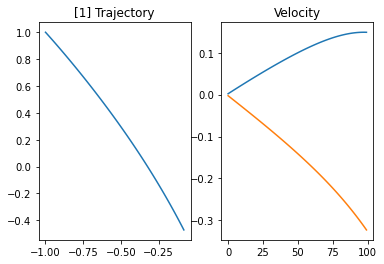

[2] loss: 0.079


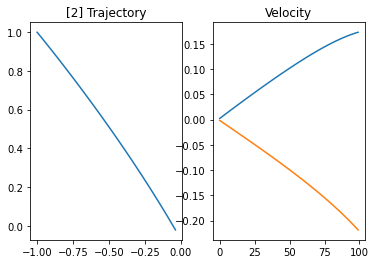

[3] loss: 0.075


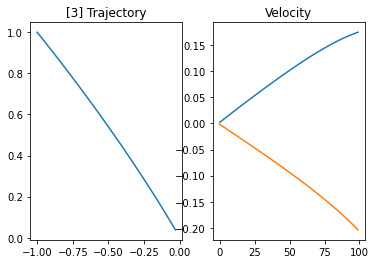

[4] loss: 0.073


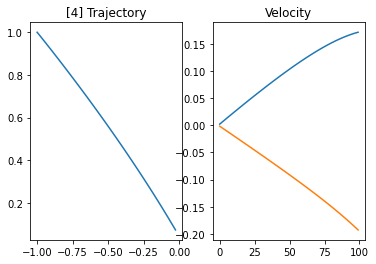

[5] loss: 0.029


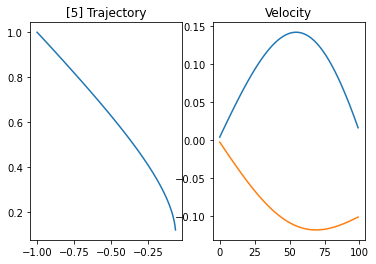

[6] loss: 0.009


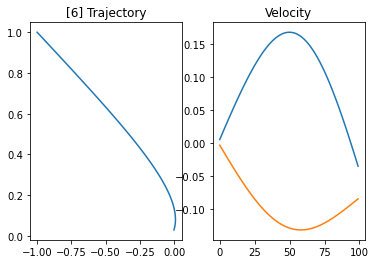

[7] loss: 0.008


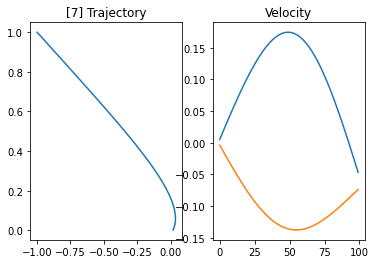

[8] loss: 0.001


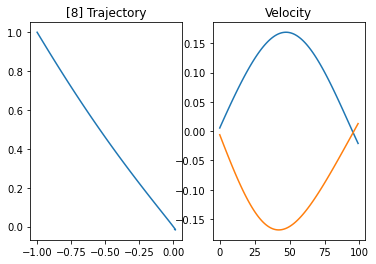

[9] loss: 0.000


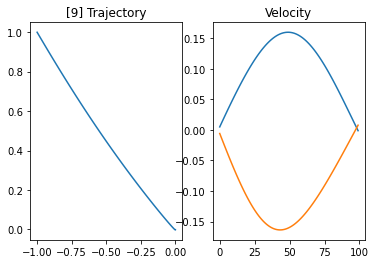

[10] loss: 0.000


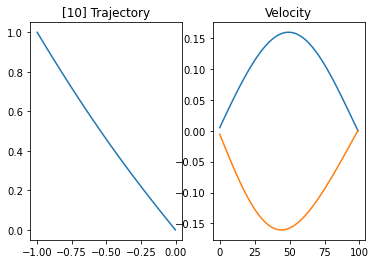

[11] loss: 0.000


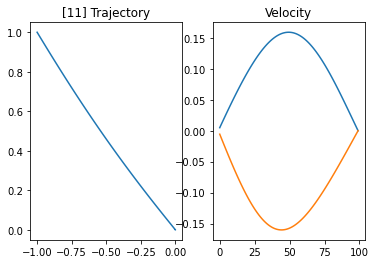

[12] loss: 0.000


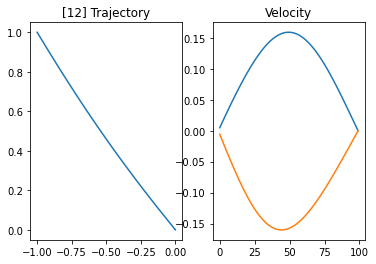

[13] loss: 0.000


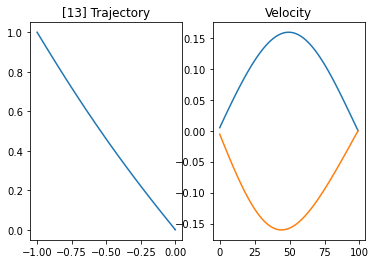

[14] loss: 0.000


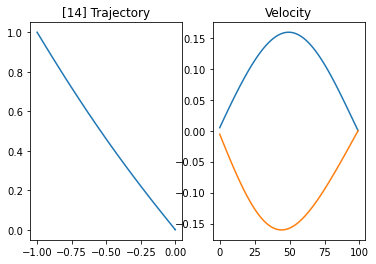

[15] loss: 0.000


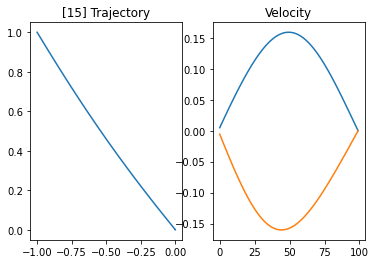

[16] loss: 0.000


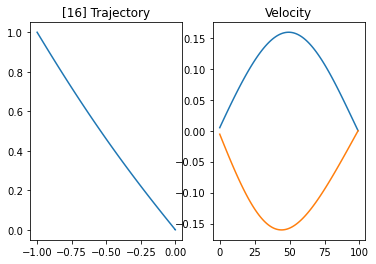

[17] loss: 0.000


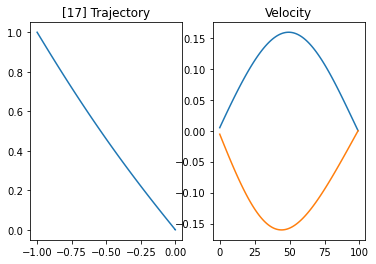

[18] loss: 0.000


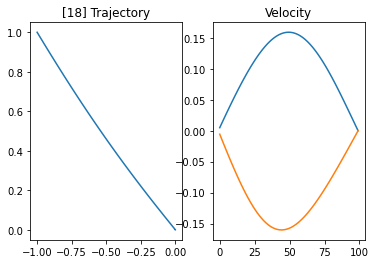

[19] loss: 0.000


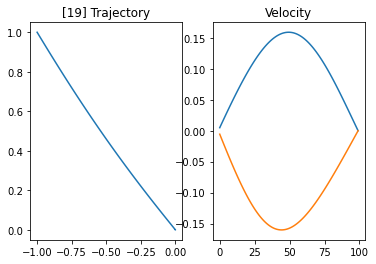

[20] loss: 0.000


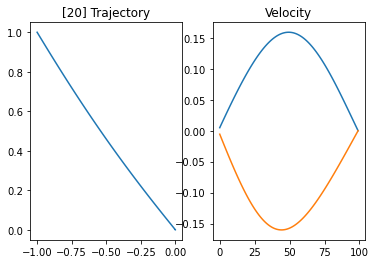

In [6]:
# Time to RUN!
T = 100  # number of time steps
dim_input = 4  # STATE SPACE dimensions. Now we have four!
dim_hidden = 8  # latent dimensions. Why not
dim_output = 2  # action space dimensions. TWO of em
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(20)  # solve the optimization problem
